### 导入需要的包

In [19]:
import torch
import os
import random
import gymnasium as gym
import numpy as np
import seaborn as sns
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.nn import functional as F
from torch.distributions import Categorical,Normal
from collections import deque

### 定义演员-评论家网络
对于gymnasium中简单的环境，简单的线性层+激活层就可以进行学习，在这里针对离散动作空间和连续动作空间设计不同的actor网络。

In [31]:
class ActorSoftmax(nn.Module):
    '''针对离散动作空间下的actor网络'''
    def __init__(self,input_dim,output_dim,hidden_dim=128):
        super(ActorSoftmax, self).__init__()
        self.fc1 = nn.Linear(input_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)
        self.fc3 = nn.Linear(hidden_dim,output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        probs = F.softmax(self.fc3(x),dim=1)
        return probs

class ActorNormal(nn.Module):
    '''针对连续动作空间下的actor网络'''
    def __init__(self,input_dim,output_dim,hidden_dim=128):
        super(ActorNormal,self).__init__()
        self.fc1 = nn.Linear(input_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)
        self.fc3 = nn.Linear(hidden_dim,output_dim)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = torch.tanh(self.fc3(x)) # 计算正态分布的均值
        sigma = F.softplus(self.fc3(x))+0.001 # 计算正态分布的方差
        sigma = torch.clamp(sigma, min=-0.25, max=0.25) # 将方差数值限制在-0.25到0.25之间
        return mu,sigma
        
class Critic(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value

### 定义智能体-A2C算法的实现
首先定义一个缓冲区，用于收集模型展开n_steps的轨迹，环境会根据选取的动作返回新的观测状态、奖励等信息，将这些信息存储在缓冲区中，在A2C算法中，等到智能体执行n步动作之后，将所有信息取出来进行之后的计算。

In [12]:
class PGReplay:
    '''创建一个缓冲区，用于策略梯度算法，每当智能体在环境中执行n步动作之后，将缓冲区中存储的信息全部提取出来计算进行网络参数更新
    '''
    def __init__(self):
        self.buffer = deque() # 创建一个缓冲区
    def push(self,transitions):
        self.buffer.append(transitions) # 将transition存储到缓冲区中
    def sample(self):
        batch = list(self.buffer)
        return zip(*batch) # 提取出所有的transition
    def clear(self):
        self.buffer.clear() # 清空缓冲区

A2C算法的基本原理是在演员-评论家算法的基础上引入优势函数的概念。评论家是一个函数逼近器，输入当前观测到的状态，输出评分值，也就是Q值。而Q值实际上可以分解为两部分，即Q(s,a)=A(s,a)+V(s)。其中A(s,a)即为优势函数，评价的是在给定状态下当前选定动作相较于其他动作的好坏，它可以通过采样数据计算得出。A2C算法的核心就在于让评论家学习A(s,a)而不再是学习Q(s,a)。

损失函数一般分为三项，策略梯度损失，值残差和策略熵正则。其中，策略梯度损失用于不断优化提升reward，值残差用于使critic网络不断逼近真实的reward，策略熵正则能够为了保证action的多样性，增加智能体探索能力。由于策略梯度损失和策略熵正则进行梯度更新的参数相同，于是将这两项进行合并。

In [23]:
class A2C:
    def __init__(self, cfg):
        self.gamma = cfg.gamma
        self.entropy_coef = cfg.entropy_coef
        self.device = torch.device(cfg.device)
        self.continuous = cfg.continuous
        if hasattr(cfg,'action_bound'):
            self.action_bound = cfg.action_bound
        self.actor = ActorSoftmax(cfg.state_dim,cfg.action_dim,hidden_dim=cfg.actor_hidden_dim).to(self.device) # 定义actor网络
        self.critic = Critic(cfg.state_dim,1,hidden_dim=cfg.critic_hidden_dim).to(self.device) # 定义critic网络
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=cfg.actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=cfg.critic_lr)
        self.memory = PGReplay() # 定义缓冲区，用于存放transition
        self.sample_count = 0 # 用于采样次数计数
        self.update_freq = cfg.update_freq # 更新策略的步数
        
    def sample_action(self,state):
        '''动作采样函数
        '''
        self.sample_count += 1
        ## 针对连续动作空间下对动作的处理
        if self.continuous:
            state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
            mu, sigma = self.actor(state)
            dist = Normal(self.action_bound * mu.view(1,), sigma.view(1,))
            action = dist.sample()
            value = self.critic(state)
            self.value = value.detach().cpu().numpy().squeeze(0)[0] # detach()操作，避免计算梯度
            self.log_prob = dist.log_prob(action).squeeze(dim=0) # Tensor([0.])
            self.entropy = dist.entropy().cpu().detach().numpy().squeeze(0) 
            return action.cpu().detach().numpy()[0]
        ## 针对离散动作空间下对动作的处理
        else:
            state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
            probs = self.actor(state)
            dist = Categorical(probs)
            action = dist.sample() # Tensor([0])
            return action.detach().cpu().numpy().item() # 将tensor数据类型转换为numpy.int64数据类型
        
    @torch.no_grad()
    def predict_action(self,state):
        '''预测动作，与动作采样函数功能相同，只是执行该函数时不需要计算梯度'''
        if self.continuous:
            state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
            mu, sigma = self.actor(state)
            dist = Normal(self.action_bound * mu.view(1,), sigma.view(1,))
            action = dist.sample()
            return action.cpu().detach().numpy()[0]
        else:
            state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
            probs = self.actor(state)
            dist = Categorical(probs)
            action = dist.sample()
            return action.detach().cpu().numpy().item()
        
    def compute_returns(self, next_value, rewards, masks):
        '''计算一个轨迹的累积奖励
        '''
        returns = torch.zeros_like(rewards)
        R = next_value
        for t in reversed(range(len(rewards))):
            R = rewards[t] + self.gamma * R * masks[t]
            returns[t] = R
        ## 归一化处理，使数值更加稳定
        returns = torch.tensor(returns, device=self.device, dtype=torch.float32).unsqueeze(1) # shape:(batch_size,1)
        returns = (returns - returns.mean()) / (returns.std() + 1e-5) # 避免除0
        return returns  
        
    def update(self,next_state):
        # 每隔n步更新策略
        if self.sample_count % self.update_freq != 0:
            return
        states, actions, rewards, masks = self.memory.sample()
        ## 转换成tensor数据类型
        states = torch.tensor(np.array(states), device=self.device, dtype=torch.float32) # shape:(batch_size,state_dim)
        actions = torch.tensor(np.array(actions), device=self.device, dtype=torch.float32) # shape:(batch_size,action_dim)
        rewards = torch.tensor(np.array(rewards), device=self.device, dtype=torch.float32) # shape:(batch_size,1)
        masks = torch.tensor(np.array(masks), device=self.device, dtype=torch.float32) # shape:(batch_size,1)
        if next_state is not None:
            next_state = torch.tensor(next_state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
            next_value = self.critic(next_state).detach().cpu().numpy().squeeze(0)[0] # 数据处理之前的shape：(1,1)
        else:
            next_value = 0 # 终止状态时，无需计算下一状态的奖励
        returns = self.compute_returns(next_value,rewards,masks) # shape:(batch_size,1)
        values = self.critic(states) # shape:(batch_size,1)
        advantages = returns - values.detach() # shape:(batch_size,1)
        probs = self.actor(states) # shape:(batch_size,action_dim)
        dist = Categorical(probs)
        log_probs = dist.log_prob(actions).unsqueeze(dim=1) # shape:(batch_size,1)
        actor_loss = (-log_probs*advantages).mean() - self.entropy_coef * dist.entropy().mean() # 计算actor网络损失函数
        critic_loss = (returns-values).pow(2).mean() # 计算critic网络损失函数
        ## 更新参数
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        critic_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.step()
        self.memory.clear() # 清除缓冲区

### 定义训练

In [41]:
def train(cfg, env, agent):
    ''' 训练
    '''
    print("开始训练！")
    rewards = []  # 记录所有回合的奖励
    steps = [] # 记录所有回合的步数
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0 # 记录一回合智能体一共走的步数
        state, info = env.reset(seed = cfg.seed)  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = agent.sample_action(state)  # 动作采样
            next_state, reward, terminated, truncated , info = env.step(action)  # 更新环境，返回transition
            agent.memory.push((state,action,reward,1-terminated)) # 将transition存储到缓冲区中
            if terminated:
                agent.update(None)
            else:
                agent.update(next_state) # 更新网络参数
            state = next_state  # 更新状态
            ep_reward += reward  # 计算累积奖励
            if terminated:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}")
    print("完成训练！")
    env.close()
    return {'rewards':rewards}

def test(cfg, env, agent):
    print("开始测试！")
    rewards = []  # 记录所有回合的奖励
    steps = [] # 记录所有回合的步数
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0 # 记录一回合智能体一共走的步数
        state, info = env.reset(seed = cfg.seed)  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step+=1
            action = agent.predict_action(state)  # 选择动作
            next_state, reward, terminated, truncated , info = env.step(action)  # 更新环境，返回transition
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if terminated:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.2f}")
    print("完成测试")
    env.close()
    return {'rewards':rewards}

### 定义环境

In [16]:
def all_seed(seed = 1):
    ''' 万能的seed函数
    '''
    if seed == 0: # 不设置seed
        return 
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = gym.make(cfg.env_id) # 创建环境
    all_seed(seed=cfg.seed) # 设置随机种子
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    print(f"状态空间维度：{state_dim}，动作空间维度：{action_dim}")
    setattr(cfg,"state_dim",state_dim) # 更新state_dim到cfg参数中
    setattr(cfg,"action_dim",action_dim) # 更新action_dim到cfg参数中
    actor = ActorSoftmax(state_dim, action_dim, hidden_dim = cfg.actor_hidden_dim) # 创建actor网络
    critic = Critic(state_dim, 1, hidden_dim =cfg.critic_hidden_dim ) # 创建critic网络
    memory = PGReplay()
    agent = A2C(cfg)
    return env,agent

### 设置参数

In [40]:
class Config:
    def __init__(self) -> None:
        self.algo_name = 'A2C' # 算法名称
        self.env_id = 'CartPole-v1' # 环境id
        self.seed = 1 # 随机种子，便于复现，0表示不设置
        self.continuous = False # 设置动作空间是离散还是连续的
        self.train_eps = 500 # 训练的回合数
        self.test_eps = 200 # 测试的回合数
        self.max_steps = 200 # 每个回合的最大步数，超过该数则游戏强制终止
        self.gamma = 0.95 # 折扣因子
        self.actor_lr = 3e-4 # actor网络学习率
        self.critic_lr= 1e-3 # critic网络学习率
        self.entropy_coef = 0.001 # 损失函数中entropy_loss的系数值
        self.actor_hidden_dim = 256 # actor网络的隐藏层维度
        self.critic_hidden_dim = 256 # critic网络的隐藏层维度
        self.update_freq = 20 # 更新策略的间隔步数
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 检测gpu
        
def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg, tag='train'):
    ''' 画图
    '''
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_id}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()
    plt.show()

### 开始训练

状态空间维度：4，动作空间维度：2
开始训练！


D:\anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


回合：10/500，奖励：18.00
回合：20/500，奖励：17.00
回合：30/500，奖励：14.00
回合：40/500，奖励：17.00
回合：50/500，奖励：40.00
回合：60/500，奖励：12.00
回合：70/500，奖励：21.00
回合：80/500，奖励：35.00
回合：90/500，奖励：28.00
回合：100/500，奖励：79.00
回合：110/500，奖励：10.00
回合：120/500，奖励：31.00
回合：130/500，奖励：48.00
回合：140/500，奖励：31.00
回合：150/500，奖励：39.00
回合：160/500，奖励：60.00
回合：170/500，奖励：81.00
回合：180/500，奖励：66.00
回合：190/500，奖励：76.00
回合：200/500，奖励：123.00
回合：210/500，奖励：47.00
回合：220/500，奖励：17.00
回合：230/500，奖励：25.00
回合：240/500，奖励：11.00
回合：250/500，奖励：25.00
回合：260/500，奖励：15.00
回合：270/500，奖励：32.00
回合：280/500，奖励：15.00
回合：290/500，奖励：59.00
回合：300/500，奖励：194.00
回合：310/500，奖励：117.00
回合：320/500，奖励：123.00
回合：330/500，奖励：94.00
回合：340/500，奖励：15.00
回合：350/500，奖励：49.00
回合：360/500，奖励：88.00
回合：370/500，奖励：55.00
回合：380/500，奖励：200.00
回合：390/500，奖励：53.00
回合：400/500，奖励：56.00
回合：410/500，奖励：57.00
回合：420/500，奖励：53.00
回合：430/500，奖励：200.00
回合：440/500，奖励：42.00
回合：450/500，奖励：116.00
回合：460/500，奖励：177.00
回合：470/500，奖励：101.00
回合：480/500，奖励：54.00
回合：490/500，奖励：93.00
回合：500/500，奖励：200.00

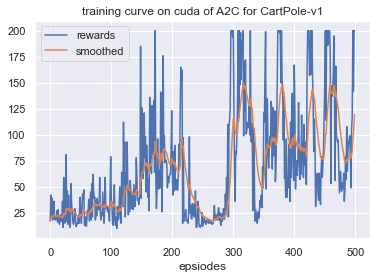

开始测试！
回合：1/200，奖励：200.00
回合：2/200，奖励：200.00
回合：3/200，奖励：200.00
回合：4/200，奖励：200.00
回合：5/200，奖励：200.00
回合：6/200，奖励：200.00
回合：7/200，奖励：200.00
回合：8/200，奖励：200.00
回合：9/200，奖励：200.00
回合：10/200，奖励：200.00
回合：11/200，奖励：200.00
回合：12/200，奖励：158.00
回合：13/200，奖励：200.00
回合：14/200，奖励：200.00
回合：15/200，奖励：200.00
回合：16/200，奖励：200.00
回合：17/200，奖励：193.00
回合：18/200，奖励：200.00
回合：19/200，奖励：200.00
回合：20/200，奖励：200.00
回合：21/200，奖励：200.00
回合：22/200，奖励：200.00
回合：23/200，奖励：200.00
回合：24/200，奖励：123.00
回合：25/200，奖励：185.00
回合：26/200，奖励：130.00
回合：27/200，奖励：200.00
回合：28/200，奖励：200.00
回合：29/200，奖励：200.00
回合：30/200，奖励：200.00
回合：31/200，奖励：200.00
回合：32/200，奖励：200.00
回合：33/200，奖励：200.00
回合：34/200，奖励：200.00
回合：35/200，奖励：200.00
回合：36/200，奖励：150.00
回合：37/200，奖励：200.00
回合：38/200，奖励：200.00
回合：39/200，奖励：200.00
回合：40/200，奖励：186.00
回合：41/200，奖励：200.00
回合：42/200，奖励：200.00
回合：43/200，奖励：149.00
回合：44/200，奖励：149.00
回合：45/200，奖励：200.00
回合：46/200，奖励：200.00
回合：47/200，奖励：200.00
回合：48/200，奖励：200.00
回合：49/200，奖励：112.00
回合：50/200，奖励：200.00
回合：

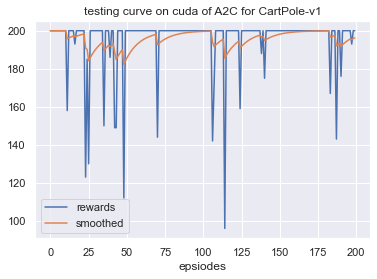

In [42]:
# 获取参数
cfg = Config() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], cfg, tag="train")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果